### Topic 1: Structural Properties of LADs
# LAD size and coverage

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part1b.LAD_size_and_coverage.heterozygous/'

In [4]:
! mkdir -p $FIGOUTDIR || true;

In [5]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [6]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [7]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = ['no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b']

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno['treatment'].isin(treatment_order)]
anno = anno[anno.cellcount == 1]
anno = anno[anno.is_heterozygous]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])

anno.head()

,runid,illumina_index,damid2_adapter_number,celseq2_adapter_number,cellcount,construct,fusion_construct,stage,treatment,genotype,...,nTranscripts,nTranscripts_maternal,nTranscripts_paternal,allelic_celseq_balance,nERCC,nMito,DamID_PASS,DamID_PASS_allelic,CELseq_PASS,stage_order
damid_name,,,,,,,,,,,,,,,,,,,,,
KIN6284.index01.DamID2_BC_001,KIN6284,1,1,1,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,32445,6140.0,6715.0,True,10,780,True,True,True,3
KIN6284.index01.DamID2_BC_002,KIN6284,1,2,2,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,1912,241.0,200.0,True,63,105,True,True,False,3
KIN6284.index01.DamID2_BC_003,KIN6284,1,3,3,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,26216,4466.0,5480.0,True,45,1069,True,True,True,3
KIN6284.index01.DamID2_BC_004,KIN6284,1,4,4,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,16230,2642.0,3172.0,True,16,613,True,True,True,3
KIN6284.index01.DamID2_BC_005,KIN6284,1,5,5,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,7235,1111.0,1367.0,True,28,369,True,True,True,3


In [9]:
df = anno.groupby(['stage', 'genotype', 'treatment']).size()
df[df>0]

stage   genotype                treatment     
zygote  CBAB6F1_x_CAST/EiJ      no_treatment       14
2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           87
                                EED_mKO            54
        CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     39
                                Lap2b              11
                                no_treatment       26
8cell   CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     35
                                no_treatment       21
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment      268
dtype: int64

## 1.2 Loading mappability

In [10]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [11]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [12]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__DamID sample counts__

In [13]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined


In [14]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined


__Contact Frequency__

In [15]:
if BINSIZE >= 100000:
    contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

        # load combined
        gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
        name = (info[1], info[2], info[3])

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        contact_freq['combined'][name] =  load_count_file(fn)

        if info[-1]:
            for parent, gt in GENOTYPE2PARENT[info[2]].items():
                gt_name = info[2].replace('/','') + '.' + gt
                fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
                contact_freq[parent][name] =  load_count_file(fn)

In [16]:
contact_freq.keys()

dict_keys(['maternal', 'paternal', 'combined'])

__in silico populations__

In [17]:
from collections import defaultdict

In [18]:
damid_insilico = {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    assert len(anno.fusion_construct.unique()) == 1
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(
        construct = info[0], stage = info[1], treatment = info[3], 
        sample = '1cell', genotype = gt_name, binsize=BINSIZE
    )
    fns = glob(fn)
    print(info, len(fns))
    name = (info[1], info[2], info[3])
    
    for fn in fns:
        counts = load_count_file(fn)
        counts = {c: counts[c].astype(int) for c in chrom_order}
        
        if name in damid_insilico['combined']:
            damid_insilico['combined'][name] = {c: damid_insilico['combined'][name][c] + counts[c] for c in chrom_order}
        else:
            damid_insilico['combined'][name] = counts

    # load parental
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = INSILICO.format(
                construct = info[0], stage = info[1], treatment = info[3], 
                sample = '1cell', genotype = gt_name, binsize=BINSIZE
            )
            fns = glob(fn)
            
            for fn in fns:
                counts =  load_count_file(fn)
                counts = {c: counts[c].astype(int) for c in chrom_order}

                if name in damid_insilico[parent]:
                    damid_insilico[parent][name] = {c: damid_insilico[parent][name][c] + counts[c] for c in chrom_order}
                else:
                    damid_insilico[parent][name] = counts
                

('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment', True) 1


__RPKM-normalization of in silico populations__

In [19]:
damid_insilico_rpkm = {p: dict() for p in ['maternal', 'paternal', 'combined']}

for sample in damid_insilico['combined']:
    gt = sample[1]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print(sample)
            continue


        if parent in ['maternal', 'paternal']:
            dm = sum([damid_insilico['maternal'][sample][c].sum() for c in chrom_order])
            dp = sum([damid_insilico['paternal'][sample][c].sum() for c in chrom_order])
            d = dm + dp

            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE, depth=d)

        else:
            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE)



__log2OE-normalization of in silico populations__

In [20]:
damid_insilico_logoe = {p: dict() for p in ['maternal', 'paternal', 'combined']}
PC = 0.1

# RPKM normalize mappability data
mapab_rpkm = dict()
for gt in mapab_gt:
    mapab_rpkm[gt] = dict()
    
    for p in mapab_gt[gt]:
        m = mapab_gt[gt][p]
        
        if p in ['maternal', 'paternal']:
            dm = sum([mapab_gt[gt]['maternal'][c].sum() for c in chrom_order])
            dp = sum([mapab_gt[gt]['paternal'][c].sum() for c in chrom_order])
            d = dm+dp
            m = rpkm_normalize(m, binsize=BINSIZE, depth=d)
        else:
            m = rpkm_normalize(m, binsize=BINSIZE)
            
        mapab_rpkm[gt][p] = m
        

# Normalize DamID data
for sample in damid_insilico['combined']:
    gt = sample[1]
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print(sample)
            continue
            
        rpkm = damid_insilico_rpkm[parent][sample]
        damid_insilico_logoe[parent][sample] = {c: np.log2( (rpkm[c] + PC) / (mapab_rpkm[gt][parent][c] + PC) ) for c in chrom_order}


__Generating single-cell averages per stage & runid__

In [21]:
## generating single-cell averages
PC = 0.1
insilico_pop_runid = dict() #{p: dict() for p in ['maternal', 'paternal', 'combined']} #defaultdict(dict)

for parent in ['maternal', 'paternal', 'combined']:

    insilico_pop_runid[parent] = {norm: dict() for norm in ['raw', 'rpkm', 'log2oe']}
    
    for (stage, genotype, treatment, runid), df in anno.groupby(['stage', 'genotype', 'treatment', 'runid']):
        samples = df.damid_name.values
    
        comb_counts = {c: np.zeros(len(mapab[c])) for c in chrom_order}

        for sample in samples:
            comb_counts = {c: comb_counts[c] + damid_counts[parent][sample][c] for c in chrom_order}

        insilico_pop_runid[parent]['raw'][(stage, genotype, treatment, runid)] = comb_counts
        if parent == 'combined':
            rpkm = rpkm_normalize(comb_counts, binsize=BINSIZE)
        else:
            d = anno.loc[samples,'maternal_damid_counts'].sum() + anno.loc[samples, 'paternal_damid_counts'].sum()
            rpkm = rpkm_normalize(comb_counts, depth=d, binsize=BINSIZE)
        
        insilico_pop_runid[parent]['rpkm'][(stage, genotype, treatment, runid)] = rpkm
        insilico_pop_runid[parent]['log2oe'][(stage, genotype, treatment, runid)] = {c: np.log2( (rpkm[c] + PC) / (mapab_rpkm[genotype][parent][c] + PC) ) for c in chrom_order}

## 1.4 Loading allele visibility

In [22]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 2. Data overview

In [23]:
chrom_lens = np.array([len(mapab[c]) for c in chrom_order])
chrom_seps = chrom_lens.cumsum()
chrom_ticks = chrom_seps - 0.5*chrom_lens

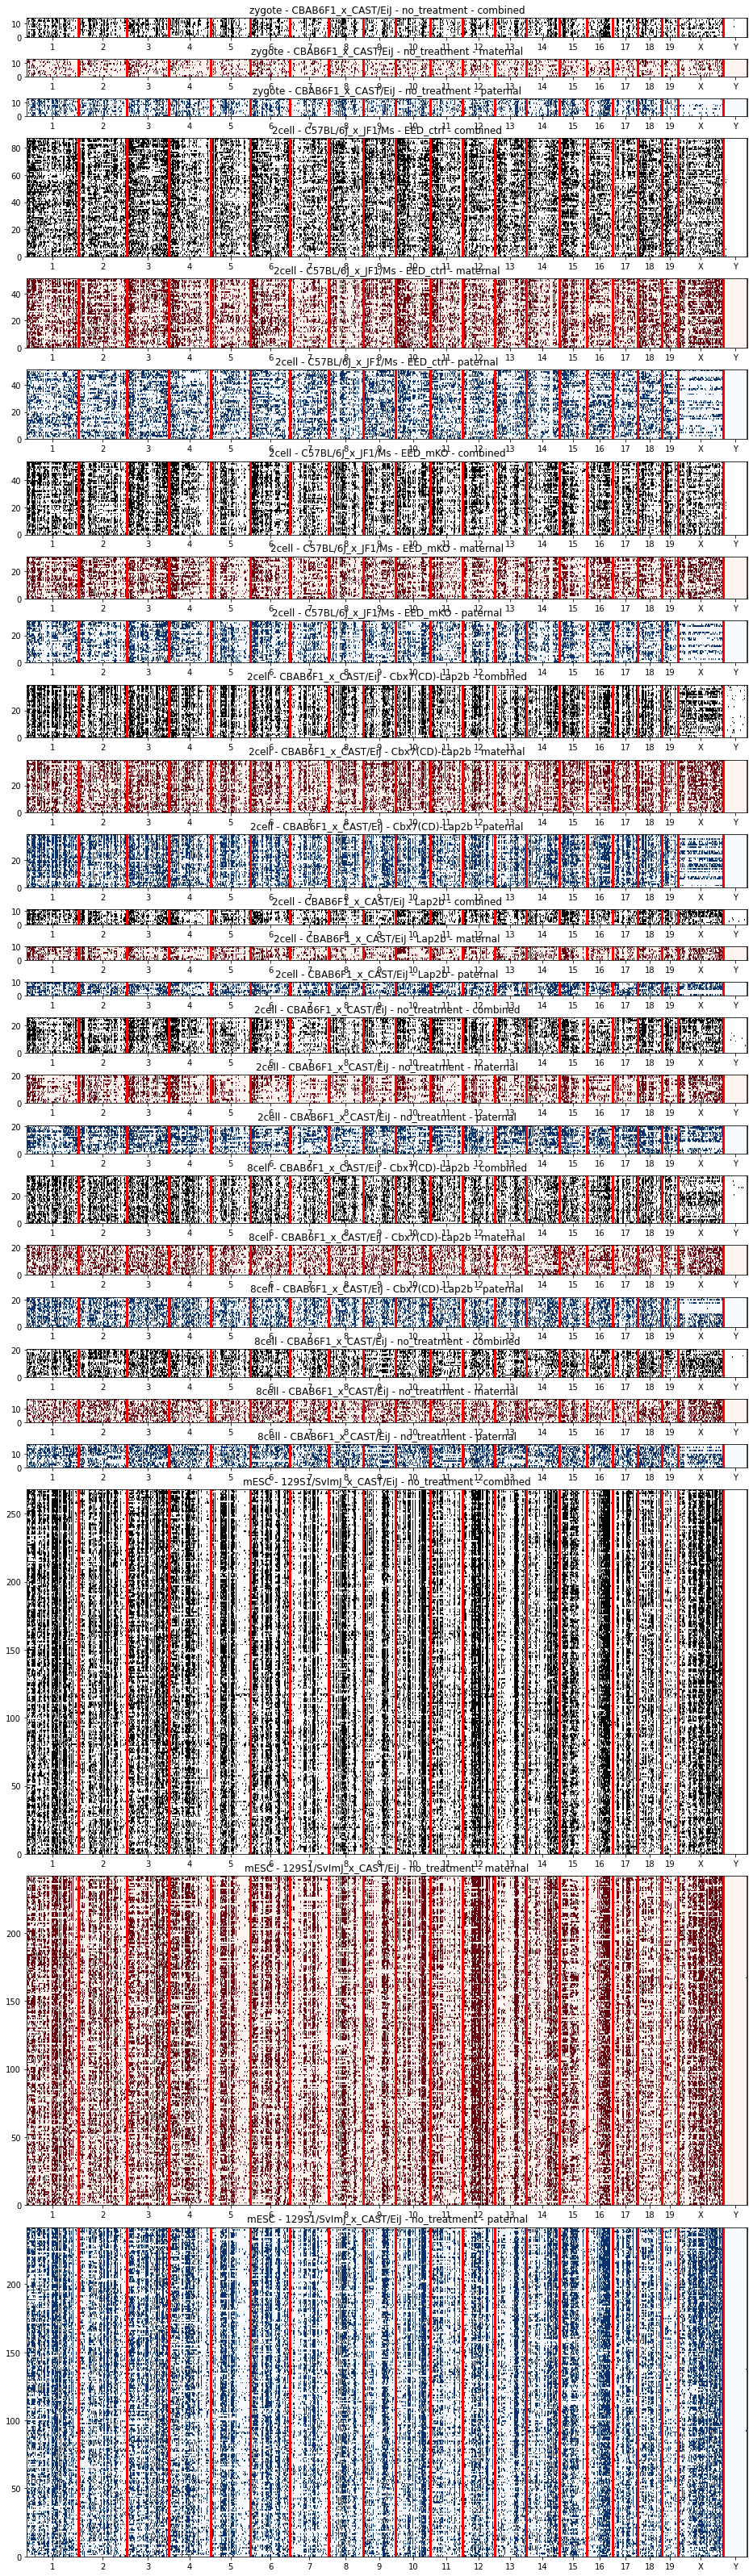

In [24]:
g = anno[anno.is_heterozygous].groupby(['stage', 'genotype', 'treatment'])
nrow = len(list(g)) * 3
ncol = 1
hr = np.concatenate([(len(df),df.DamID_PASS_allelic.sum(),df.DamID_PASS_allelic.sum()) for _, df in g])
fig = plt.figure(figsize=(16, sum(hr)*0.04)) 
gs = gridspec.GridSpec(nrow, ncol, height_ratios=hr, hspace=0.3)
counter = 0

for (stage, genotype, treatment), df in g:
    for parent in ['combined', 'maternal', 'paternal']:
        Y = list()

        if parent == 'combined':
            samples = df.sort_values(by='unique_damid_counts').damid_name.values
        else:
            samples = df[df.DamID_PASS_allelic].sort_values(by='unique_damid_counts').damid_name.values
        
        for s in samples:
            y = np.concatenate([damid_binary[parent][s][c] for c in chrom_order])
            Y.append(y)
        Y = np.array(Y)

        ax = plt.subplot(gs[counter])
        counter += 1

        cmap = {'combined': 'binary', 'maternal': 'Reds', 'paternal': 'Blues'}[parent]
        ax.pcolorfast(Y, cmap=cmap)
        ax.set_title('%s - %s - %s - %s' % (stage, genotype, treatment, parent))

        for x in chrom_seps:
            ax.axvline(x, c='r', lw=3)
        ax.set_xticks(chrom_ticks)
        ax.set_xticklabels(chrom_order)

# 3. Question 1: What fraction of the genome is in contact with the NL?

## 3.1 Percent of genome in contact with the NL per stage
Excluding chrX&Y

In [24]:
from collections import defaultdict

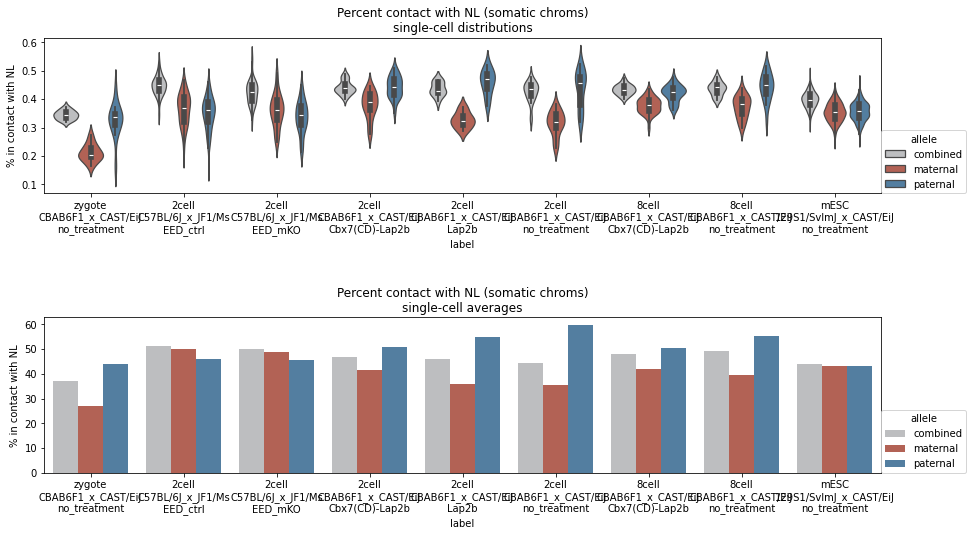

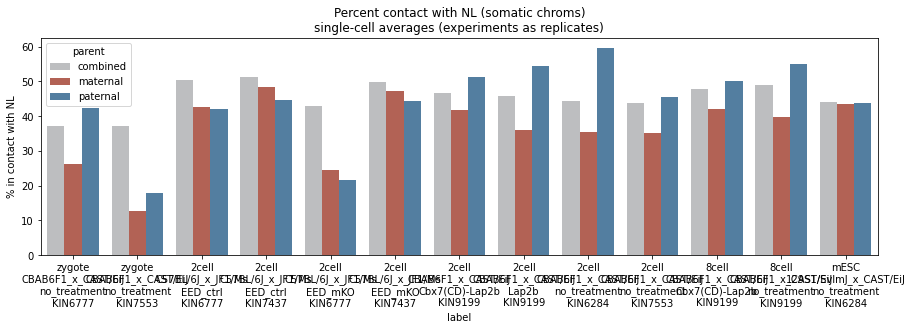

In [25]:
fig, axes = plt.subplots(2,1, figsize=(15,8))
plt.subplots_adjust(hspace=.8)


# plotting single-cell distributions
ax = axes[0]
tmp = anno.loc[(anno.cellcount==1) & (anno.is_heterozygous), ['stage', 'genotype', 'treatment', 'unique_damid_counts']].copy()
tmp = tmp.reset_index()
to_plot_ls = list()
for parent in ['maternal', 'paternal', 'combined']:
    df = tmp.copy()
    df['parent'] = parent
    to_plot_ls.append(df)
to_plot = pd.concat(to_plot_ls, axis=0).reset_index(drop=True)

som_chrom = np.arange(1,20).astype(str)
m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP

for irow, row in to_plot.iterrows():
    sample = row['damid_name']
    parent = row['parent']
    genotype = row['genotype']
    
    a_ind = np.concatenate([allele_filt_gt[genotype][c] for c in som_chrom])
    filt = m_ind & a_ind if parent != 'combined' else m_ind
    
    counts = np.concatenate([damid_binary[parent][sample][c] for c in som_chrom])
    
    to_plot.loc[irow, 'frac_contact'] = counts[filt].mean()

to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))
order = to_plot.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()
sns.violinplot(
    x=to_plot['label'], y=to_plot['frac_contact'], hue=to_plot['parent'], palette=color_dict['allele'],
    order=order, hue_order=['combined', 'maternal', 'paternal'], ax=ax
)
ax.set_ylabel('% in contact with NL')
ax.set_title('Percent contact with NL (somatic chroms)\nsingle-cell distributions')
ax.legend(loc=(1,0), title='allele')

to_plot_sc = to_plot.copy()

# plotting in silico pops
to_plot = defaultdict(list)
for parent in ['combined', 'maternal', 'paternal']:
    for sample, counts in damid_insilico_logoe[parent].items():
        counts = (np.concatenate([counts[c] for c in som_chrom]) > 0).astype(int)
        
        a_ind = np.concatenate([allele_filt_gt[sample[1]][c] for c in som_chrom])
        filt = m_ind & a_ind if parent != 'combined' else m_ind
        
        f = counts[filt].mean()
        to_plot['label'].append('\n'.join(sample))
        to_plot['frac_contact'].append(f)
        to_plot['stage'].append(sample[0])
        to_plot['genotype'].append(sample[1])
        to_plot['treatment'].append(sample[2])
        to_plot['parent'].append(parent)
    
to_plot = pd.DataFrame(to_plot)

ax = axes[1]
sns.barplot(
    x=to_plot.label, y=to_plot.frac_contact*100, hue=to_plot.parent, palette=color_dict['allele'],
    order=order, hue_order=['combined', 'maternal', 'paternal'], ax=ax, dodge=True
)
ax.set_title('Percent contact with NL (somatic chroms)\nsingle-cell averages')
ax.set_ylabel('% in contact with NL')
ax.legend(loc=(1,0), title='allele')

outfn = FIGOUTDIR + 'percentage_of_genome_contacting_NL.allelic.pdf'
plt.savefig(outfn, bbox_inches='tight')

plt.show()
plt.close()

  
# plotting in silico pops - split by runid
to_plot = defaultdict(list)
for parent in ['combined', 'maternal', 'paternal']:
    for pop, counts in insilico_pop_runid[parent]['log2oe'].items():
        counts = (np.concatenate([counts[c] for c in som_chrom]) > 0).astype(int)
        f = counts[m_ind].mean()
        to_plot['label'].append('\n'.join(pop))
        to_plot['stage'].append(pop[0])
        to_plot['genotype'].append(pop[1])
        to_plot['treatment'].append(pop[2])
        to_plot['runid'].append(pop[3])
        to_plot['parent'].append(parent)
        to_plot['frac_contact'].append(f)
        
    
to_plot = pd.DataFrame(to_plot)

fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x=to_plot.label, y=to_plot.frac_contact*100, hue=to_plot.parent, palette=color_dict['allele'], ax=ax)
ax.set_title('Percent contact with NL (somatic chroms)\nsingle-cell averages (experiments as replicates)')
ax.set_ylabel('% in contact with NL')

plt.show()

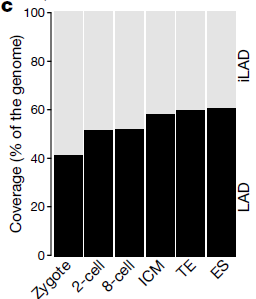  

Figure 1c from Borsos _et al_ (2019), equivalent to the right plot.

It's obvious that the zygote has fewer NL interactions that the 2cell stage and mESCs. It's very powerful that the data is good enough that we can quantify this reliably per cell, because population averages may give an inaccurate picture in the more variable stages (i.e. 2cell stage). I am curious to see how other other stages perform. I would expect a gradual increase from the zygote to the mESC, with the 2cell stage being an exception.

__Perform statistical test on comparison between maternal and paternal allele of single-cell data__

In [27]:
stat_results = defaultdict(list)

for (stage, genotype, treatment), df in to_plot_sc.groupby(['stage', 'genotype', 'treatment']):
    
    # compare maternal and paternal allele
    stat_results['stage'].append(stage)
    stat_results['genotype'].append(genotype)
    stat_results['treatment'].append(treatment)
    stat_results['sample_1'].append('maternal')
    stat_results['sample_2'].append('paternal')

    A = df.loc[(df.parent == 'maternal'), 'frac_contact'].values
    B = df.loc[(df.parent == 'paternal'), 'frac_contact'].values
    result = stats.ranksums(A, B, alternative='two-sided')

    stat_results['N_1'].append(len(A))
    stat_results['N_2'].append(len(B))
    stat_results['wilcox_stat'].append(result[0])
    stat_results['wilcox_pval'].append(result[1])
    stat_results['mean_sample_1'].append(A.mean())
    stat_results['mean_sample_2'].append(B.mean())
    stat_results['median_sample_1'].append(np.median(A))
    stat_results['median_sample_2'].append(np.median(B))
    stat_results['std_1'].append(np.std(A))
    stat_results['std_2'].append(np.std(B))
    
stat_results = pd.DataFrame(stat_results)

outfn = FIGOUTDIR + 'percentage_of_genome_contacting_NL.allelic.statistical_test_results.tsv'
stat_results.to_csv(outfn, sep='\t', header=True, index=False)

### Percent genome in contact with NL, including category of both alleles combined

label                   allele           
2cell - Cbx7(CD)-Lap2b  combined              39
                        maternal              39
                        maternal+paternal     39
                        paternal              39
2cell - EED_ctrl        combined              51
                        maternal              51
                        maternal+paternal     51
                        paternal              51
2cell - EED_mKO         combined              31
                        maternal              31
                        maternal+paternal     31
                        paternal              31
2cell - Lap2b           combined              10
                        maternal              10
                        maternal+paternal     10
                        paternal              10
2cell - no_treatment    combined              21
                        maternal              21
                        maternal+paternal     21
                        pat

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4296/1880072125.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


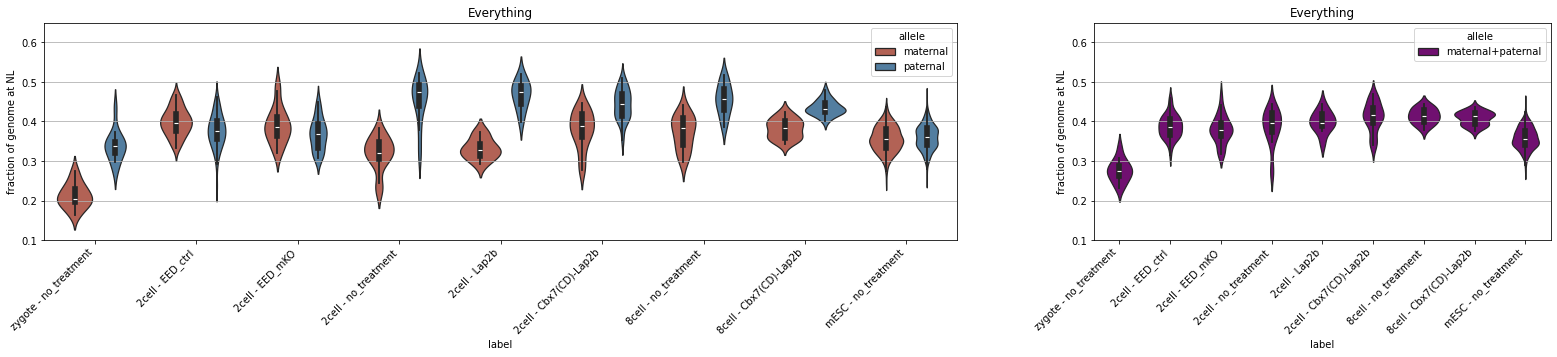

label                  allele           
2cell - no_treatment   combined              21
                       maternal              21
                       maternal+paternal     21
                       paternal              21
8cell - no_treatment   combined              17
                       maternal              17
                       maternal+paternal     17
                       paternal              17
mESC - no_treatment    combined             242
                       maternal             242
                       maternal+paternal    242
                       paternal             242
zygote - no_treatment  combined              13
                       maternal              13
                       maternal+paternal     13
                       paternal              13
dtype: int64


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4296/1880072125.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


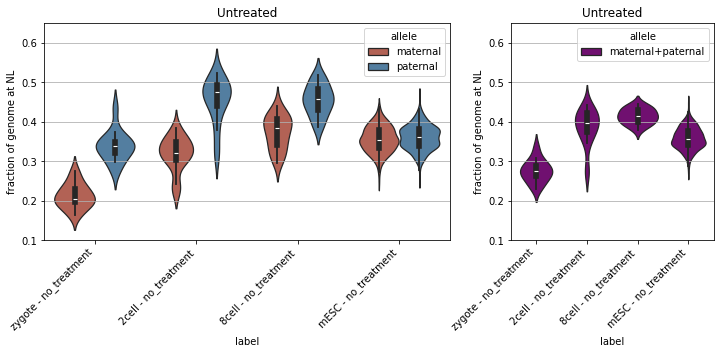

label             allele           
2cell - EED_ctrl  combined             51
                  maternal             51
                  maternal+paternal    51
                  paternal             51
2cell - EED_mKO   combined             31
                  maternal             31
                  maternal+paternal    31
                  paternal             31
dtype: int64


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4296/1880072125.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


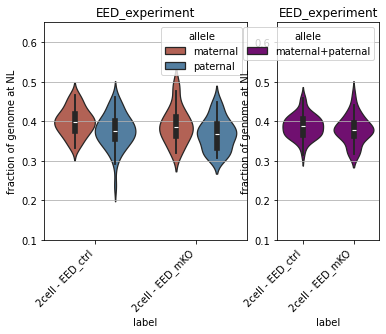

label                   allele           
2cell - Cbx7(CD)-Lap2b  combined             39
                        maternal             39
                        maternal+paternal    39
                        paternal             39
2cell - Lap2b           combined             10
                        maternal             10
                        maternal+paternal    10
                        paternal             10
2cell - no_treatment    combined             21
                        maternal             21
                        maternal+paternal    21
                        paternal             21
8cell - Cbx7(CD)-Lap2b  combined             22
                        maternal             22
                        maternal+paternal    22
                        paternal             22
8cell - no_treatment    combined             17
                        maternal             17
                        maternal+paternal    17
                        paternal             1

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4296/1880072125.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


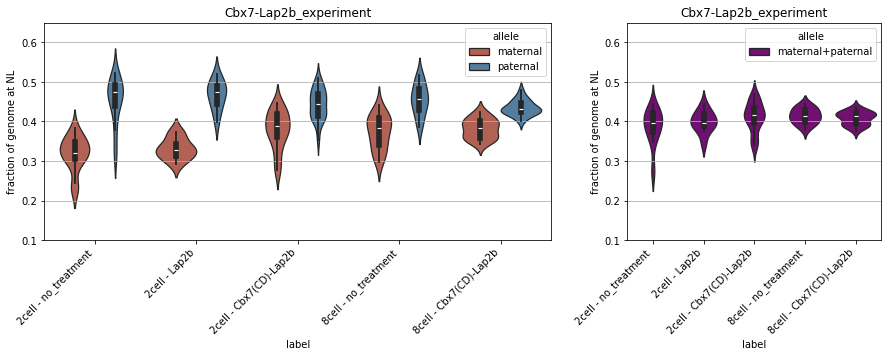

label                   allele           
2cell - Cbx7(CD)-Lap2b  combined             39
                        maternal             39
                        maternal+paternal    39
                        paternal             39
2cell - EED_ctrl        combined             51
                        maternal             51
                        maternal+paternal    51
                        paternal             51
2cell - EED_mKO         combined             31
                        maternal             31
                        maternal+paternal    31
                        paternal             31
2cell - Lap2b           combined             10
                        maternal             10
                        maternal+paternal    10
                        paternal             10
2cell - no_treatment    combined             21
                        maternal             21
                        maternal+paternal    21
                        paternal             2

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4296/1880072125.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


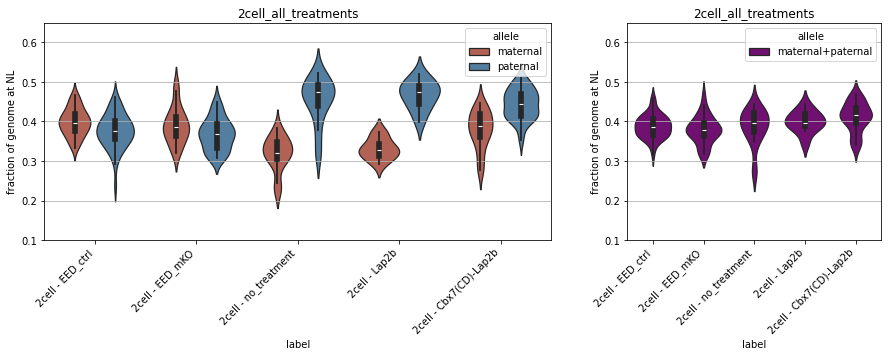

In [26]:
ind = (anno.cellcount==1) & (anno.is_heterozygous) & (anno.DamID_PASS_allelic)

plot_groups = {
    'Everything': ind,
    'Untreated': ind & (anno.treatment == 'no_treatment'),
    'EED_experiment': ind & (anno.treatment.isin(['EED_ctrl', 'EED_mKO'])),
    'Cbx7-Lap2b_experiment': ind & anno.stage.isin(['2cell', '8cell']) & anno.treatment.isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b']),
    '2cell_all_treatments': ind & (anno.stage == '2cell')
}


for title, ind in plot_groups.items():
    
    # select relevant data
    tmp = anno.loc[ind, ['stage', 'genotype', 'treatment', 'unique_damid_counts']].copy()
    to_plot = tmp.reset_index()
    to_plot['stage'] = pd.Categorical(to_plot['stage'], categories=stage_order)
    to_plot['treatment'] = pd.Categorical(to_plot['treatment'], categories=treatment_order)
    n1 = len(list(to_plot.groupby(['stage','genotype','treatment'])))
    n2 = len(list(to_plot.groupby(['stage','treatment'])))
    if n1 == n2:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s - %s' % (r['stage'], r['treatment']))
    else:
        to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s - %s\n(%s)' % (r['stage'], r['treatment'], r['genotype']))
    label_order = to_plot.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()
    
    # collect fraction contact per allele
    som_chrom = np.arange(1,20).astype(str)
    m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP
    to_plot['total_mappable_bins'] = m_ind.sum()

    for irow, row in to_plot.iterrows():
        sample = row['damid_name']
        genotype = row['genotype']

        a_ind = np.concatenate([allele_filt_gt[genotype][c] for c in som_chrom])
#         a_ind = np.concatenate([allele_filt_total[c] for c in som_chrom])
        to_plot.loc[irow, 'total_allelic_bins'] = (a_ind & m_ind).sum()

        for parent in ['maternal', 'paternal', 'combined']:

            filt = m_ind & a_ind #if parent != 'combined' else m_ind
            counts = np.concatenate([damid_binary[parent][sample][c] for c in som_chrom])
            to_plot.loc[irow, 'frac_contact_%s' % parent] = counts[filt].mean()
            to_plot.loc[irow, 'n_bins_contact_%s' % parent] = counts[filt].sum()
    
    # format dataframe
    to_plot = to_plot[['damid_name', 'label', 'total_allelic_bins', 'frac_contact_maternal', 'frac_contact_paternal', 'frac_contact_combined']]
    to_plot.columns = ['damid_name', 'label', 'total_allelic_bins', 'maternal', 'paternal', 'combined']
    to_plot['maternal+paternal'] = (to_plot['maternal'] + to_plot['paternal'])/2
    to_plot = to_plot.melt(id_vars=['damid_name', 'total_allelic_bins', 'label'], var_name='allele', value_name='frac_contact')

    
    figw = len(label_order)*3
    fig, axes = plt.subplots(1,2, figsize=(figw,4), gridspec_kw={'width_ratios': [2,1]})

    tmp = color_dict['allele'].copy()
    tmp['maternal+paternal'] = 'purple'

    ax = axes[0]
    sns.violinplot(
        x = to_plot['label'], y = to_plot['frac_contact'], hue = to_plot['allele'], ax=ax, 
        palette=tmp, order=label_order, hue_order=['maternal', 'paternal']
    )

    ax = axes[1]
    sns.violinplot(
        x = to_plot['label'], y = to_plot['frac_contact'], hue = to_plot['allele'], ax=ax, 
        palette=tmp, order=label_order, hue_order=['maternal+paternal']
    )
    
    print(to_plot.groupby(['label', 'allele']).size())

    for ax in axes:
        ax.set_ylabel('fraction of genome at NL')
        ax.grid(axis='y')
        ax.set_ylim(0.1,0.65)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title(title)
        
        
    outfn = FIGOUTDIR + 'percentage_of_genome_contacting_NL.allelic.%s.pdf' % title
    plt.savefig(outfn, bbox_inches='tight')
    plt.show()
    plt.close()

__Same plot, only data generated by Kind__

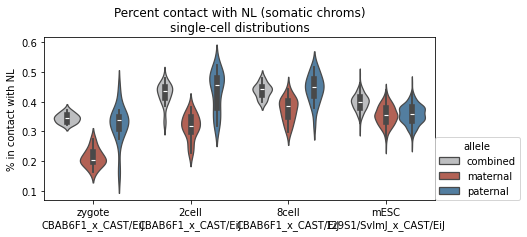

In [29]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
plt.subplots_adjust(hspace=.8)


# plotting single-cell distributions
ind = (anno.cellcount==1) & (anno.is_heterozygous) & (anno.genotype != 'C57BL/6J_x_JF1/Ms') & (anno.treatment=='no_treatment')
tmp = anno.loc[ind, ['stage', 'genotype', 'treatment', 'unique_damid_counts']].copy()
tmp = tmp.reset_index()
to_plot_ls = list()
for parent in ['maternal', 'paternal', 'combined']:
    df = tmp.copy()
    df['parent'] = parent
    to_plot_ls.append(df)
to_plot = pd.concat(to_plot_ls, axis=0).reset_index(drop=True)

som_chrom = np.arange(1,20).astype(str)
m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP

for irow, row in to_plot.iterrows():
    sample = row['damid_name']
    parent = row['parent']
    genotype = row['genotype']
    
    a_ind = np.concatenate([allele_filt_gt[genotype][c] for c in som_chrom])
    filt = m_ind & a_ind if parent != 'combined' else m_ind
    
    counts = np.concatenate([damid_binary[parent][sample][c] for c in som_chrom])
    
    to_plot.loc[irow, 'frac_contact'] = counts[filt].mean()

to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s\n%s' % (r['stage'], r['genotype']))
order = to_plot.sort_values(by=['stage', 'genotype'])['label'].unique()
sns.violinplot(
    x=to_plot['label'], y=to_plot['frac_contact'], hue=to_plot['parent'], palette=color_dict['allele'],
    order=order, hue_order=['combined', 'maternal', 'paternal'], ax=ax
)
ax.set_ylabel('% in contact with NL')
ax.set_title('Percent contact with NL (somatic chroms)\nsingle-cell distributions')
ax.legend(loc=(1,0), title='allele')
ax.set_xlabel('')


outfn = FIGOUTDIR + 'percentage_of_genome_contacting_NL.allelic.Kind_samples_only.pdf'
plt.savefig(outfn, bbox_inches='tight')

plt.show()
plt.close()

### Percent of chromosomes in contact with the NL per stage

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_13881/3263129498.py:16: RuntimeWarning: Mean of empty slice.
  to_plot['frac_contact'].append(damid_binary[parent][sample][chrom][filt].mean())
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


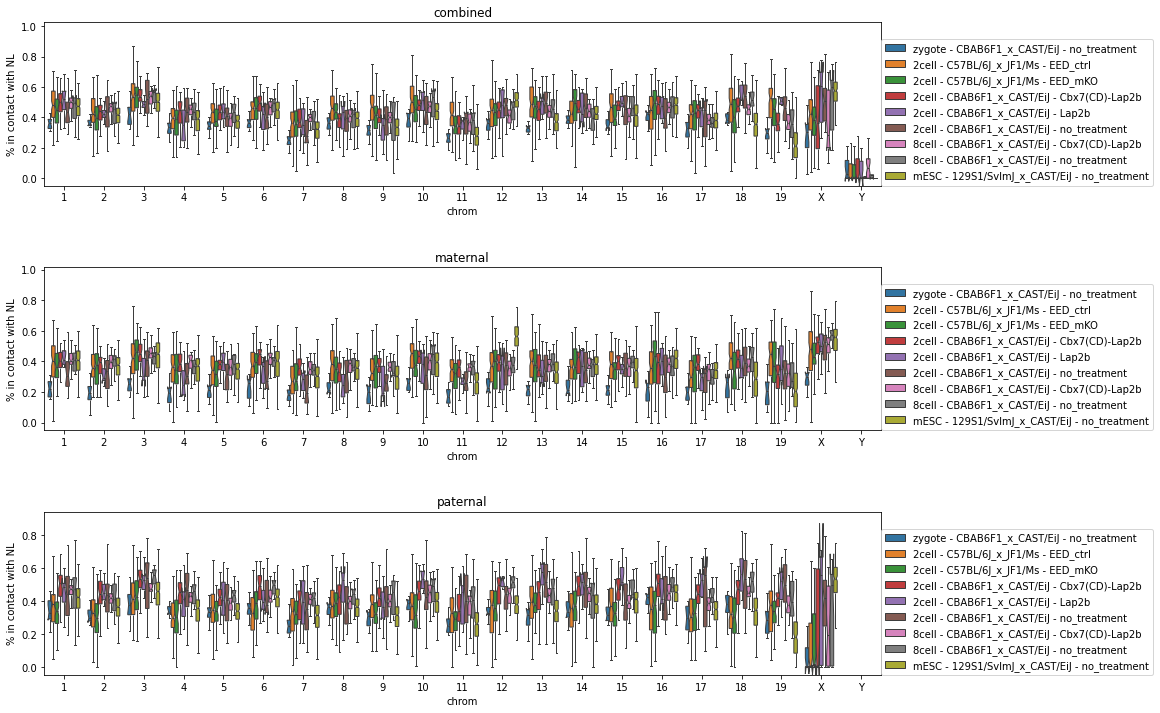

In [30]:
to_plot = defaultdict(list)

for info, df in anno[anno.cellcount == 1].groupby(['stage', 'genotype', 'treatment']):
    
    for sample in df.index.values:
        for chrom in chrom_order:
            for parent in ['combined', 'maternal', 'paternal']:
                m_ind = mapab[chrom] > MINMAP
                filt = m_ind if parent == 'combined' else (m_ind & allele_filt_gt[info[1]][chrom])
                to_plot['sample'].append(sample)
                to_plot['stage'].append(info[0])
                to_plot['genotype'].append(info[1])
                to_plot['treatment'].append(info[2])
                to_plot['parent'].append(parent)
                to_plot['chrom'].append(chrom)
                to_plot['frac_contact'].append(damid_binary[parent][sample][chrom][filt].mean())
    
to_plot = pd.DataFrame(to_plot)
to_plot['stage'] = pd.Categorical(to_plot['stage'], categories=stage_order)
to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s - %s - %s' % (r['stage'], r['genotype'], r['treatment']))

fig, axes = plt.subplots(3, 1, figsize=(15,12))
plt.subplots_adjust(hspace=.5)

horder = to_plot.sort_values(by=['stage', 'genotype', 'treatment'])['label'].unique()

for irow, parent in enumerate(['combined', 'maternal', 'paternal']):
    ax = axes[irow]
    ax.set_title(parent)
    
    df = to_plot[to_plot.parent==parent]

    sns.boxplot(x=df['chrom'], y=df['frac_contact'], hue=df['label'], 
                order=chrom_order, hue_order=horder, notch=True, fliersize=0, ax=ax)
    
    ax.set_ylabel('% in contact with NL')
    ax.legend(loc=(1,0))

plt.show()

### Observations:
Chromosomes with interesting behaviour:
- chr3,chr12,chr16 --> very strong enrichment in mESC (could be due to chr12 duplication for mESC)
- chr9,chr11,chr18,chr19 --> weak enrichment in mESC compared to zygote
- chrX --> progressively stronger enrichment over development (mESC is female)

Interesting comparison between chr11 en chr12: why do two chromosomes so similar in size, behave so differently?

NOTE: mESC line is female and therefore does not have a chrY. The embryos are mixed sexes.

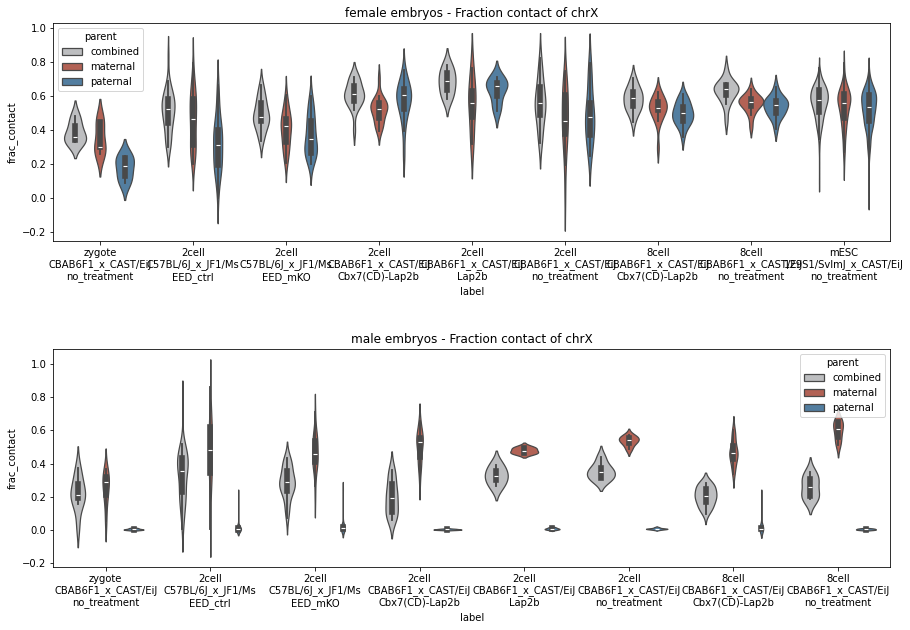

frac_contact            \
parent                                                  combined  maternal   
stage  genotype               treatment      sex                             
zygote CBAB6F1_x_CAST/EiJ     no_treatment   female     0.358041  0.300613   
                                             male       0.208471  0.291411   
2cell  C57BL/6J_x_JF1/Ms      EED_ctrl       female     0.522502  0.466422   
                                             male       0.354732  0.483736   
                              EED_mKO        female     0.477167  0.426023   
                                             male       0.287227  0.454355   
       CBAB6F1_x_CAST/EiJ     Cbx7(CD)-Lap2b female     0.609530  0.520706   
                                             male       0.194242  0.532592   
                              Lap2b          female     0.685639  0.560583   
                                             male       0.326936  0.476610   
                              no_treatment   female     0.557578  0.454371   
                                             male       0.350430  0.542178   
8cell  CBAB6F1_x_CAST/EiJ     Cbx7(CD)-Lap2b female     0.585705  0.530675   
                                             male       0.201522  0.463190   
                              no_treatment   female     0.640635  0.563650   
                                             male       0.259431  0.606595   
mESC   129S1/SvImJ_x_CAST/EiJ no_treatment   female     0.576439  0.558506   

                                                               
parent                                               paternal  
stage  genotype               treatment      sex               
zygote CBAB6F1_x_CAST/EiJ     no_treatment   female  0.186350  
                                             male    0.003834  
2cell  C57BL/6J_x_JF1/Ms      EED_ctrl       female  0.310598  
                                             male    0.005247  
                              EED_mKO        female  0.346275  
                                             male    0.012592  
       CBAB6F1_x_CAST/EiJ     Cbx7(CD)-Lap2b female  0.602761  
                                             male    0.003067  
                              Lap2b          female  0.655675  
                                             male    0.006518  
                              no_treatment   female  0.477377  
                                             male    0.007285  
8cell  CBAB6F1_x_CAST/EiJ     Cbx7(CD)-Lap2b female  0.496933  
                                             male    0.007285  
                              no_treatment   female  0.549080  
                                             male    0.004601  
mESC   129S1/SvImJ_x_CAST/EiJ no_treatment   female  0.536515

In [31]:
to_plot2 = to_plot[to_plot.chrom == 'X'].copy()
to_plot2['sex'] = anno.loc[to_plot2['sample'].values, 'sex'].values
to_plot2['label'] = to_plot2.apply(axis=1, func = lambda r: '%s\n%s\n%s' % (r['stage'], r['genotype'], r['treatment']))


fig, axes = plt.subplots(2,1,figsize=(15,10))
plt.subplots_adjust(hspace=.5)

for icol, sex in enumerate(['female', 'male']):
    ax = axes[icol]
    
    df = to_plot2[to_plot2.sex==sex]
    sns.violinplot(x=df['label'], y=df['frac_contact'], hue=df['parent'], palette=color_dict['allele'], ax=ax)

    ax.set_title('%s embryos - Fraction contact of chrX' % sex)
plt.show()

tmp = to_plot2.groupby(['stage', 'genotype', 'treatment', 'sex', 'parent']).agg({'frac_contact': np.median}).unstack().loc[stage_order,:]
tmp[~tmp[('frac_contact', 'paternal')].isna()]


Interesting that in male embryos, the chrX seems to have a fairly stable part associated with the NL (21-30%), while in female embryos, this percentage increases dramatically. This suggests that at least one of the alleles is becoming progressively associated with the NL.

## Question 2: How variable are contacts at different stages?

### CF distribution per stage

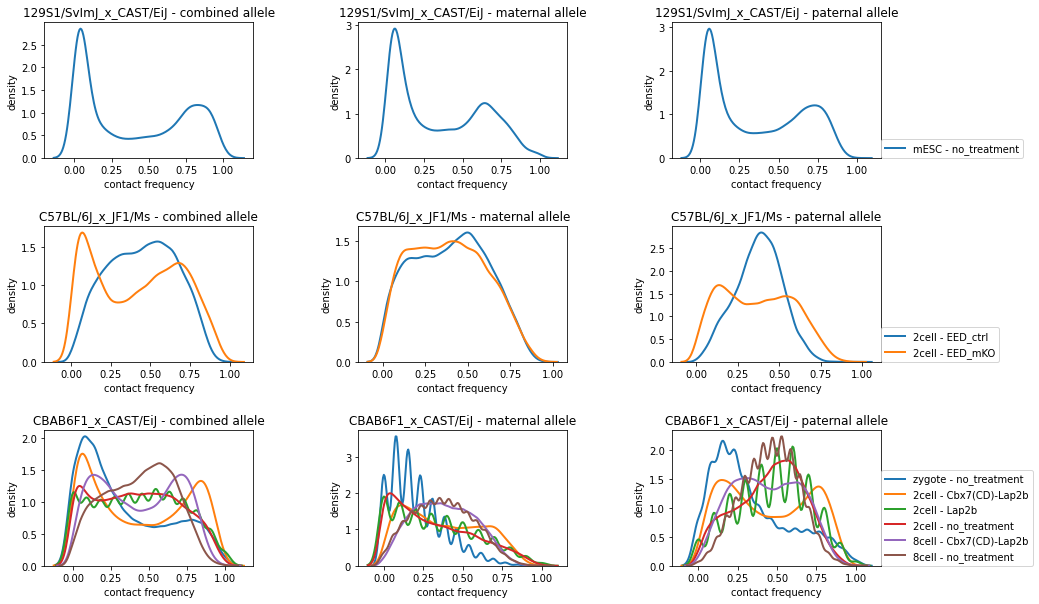

In [32]:
g_anno = anno.groupby('genotype')
nrow = len(g_anno)
ncol = 3

fig, axes = plt.subplots(nrow,ncol,figsize=(15,10))
plt.subplots_adjust(hspace=.5, wspace=.5)
irow = -1

m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP

for genotype, df_gt in g_anno:
    irow += 1
    
    for icol, parent in enumerate(['combined', 'maternal', 'paternal']):
        ax = axes[irow,icol]
        ax.set_title('%s - %s allele' % (genotype, parent))

        for sample, _ in df_gt.groupby(['stage','genotype','treatment']):
            X = np.concatenate([contact_freq[parent][sample][c] for c in som_chrom])

            a_ind = np.concatenate([allele_filt_gt[sample[1]][c] for c in som_chrom])
            filt = m_ind if parent == 'combined' else a_ind & m_ind

            l = '%s - %s' % (sample[0], sample[2])
            sns.kdeplot(X[filt], label=l, ax=ax, lw=2)

        ax.set_xlabel('contact frequency')
        ax.set_ylabel('density')
        if parent == 'paternal':
            ax.legend(loc=(1,0))
    
outfn = FIGOUTDIR + 'contact_frquency_distribution.allelic.pdf'
plt.savefig(outfn, bbox_inches='tight')
plt.show()

### Log2OE value distribution for single-cell averages

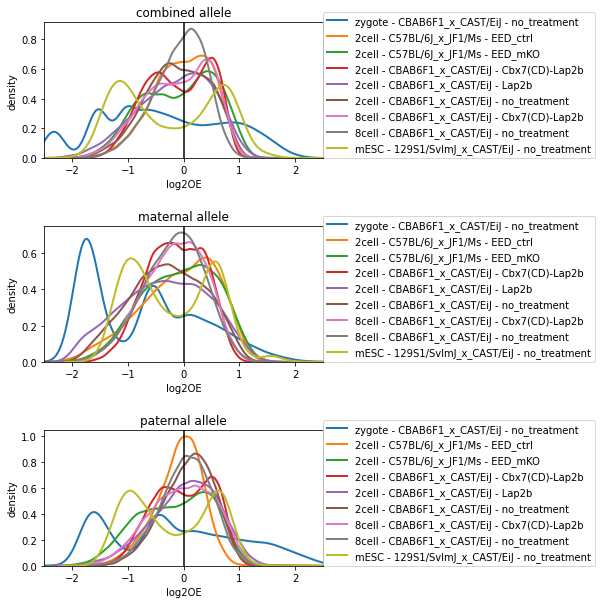

In [33]:
fig, axes = plt.subplots(3,1,figsize=(5,10))
plt.subplots_adjust(hspace=.5)

m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP


for irow, parent in enumerate(['combined', 'maternal', 'paternal']):
    ax = axes[irow]
    
    for i, sample in enumerate(damid_insilico_logoe[parent]):
        X = np.concatenate([damid_insilico_logoe[parent][sample][c] for c in som_chrom])

        a_ind = np.concatenate([allele_filt_gt[sample[1]][c] for c in som_chrom])
        filt = m_ind if parent == 'combined' else a_ind & m_ind

        sns.kdeplot(X[filt], label='%s - %s - %s' % sample, ax=ax, lw=2)

    ax.legend(loc=(1,0))
    ax.set_xlabel('log2OE')
    ax.set_ylabel('density')
    ax.set_xlim(-2.5,2.5)
    ax.axvline(0, c='k')
    ax.set_title('%s allele' % parent)
    
outfn = FIGOUTDIR + 'log2OE_insilico_distribution.allelic.pdf'
plt.savefig(outfn, bbox_inches='tight')
plt.show()

### Log2OE value distributions for single-cell averages per run
If the log2OE value distributions are similar between experiments, I have hopes that the differences in CF distributions between stages are indeed due to true biological differences rather than technical differences.

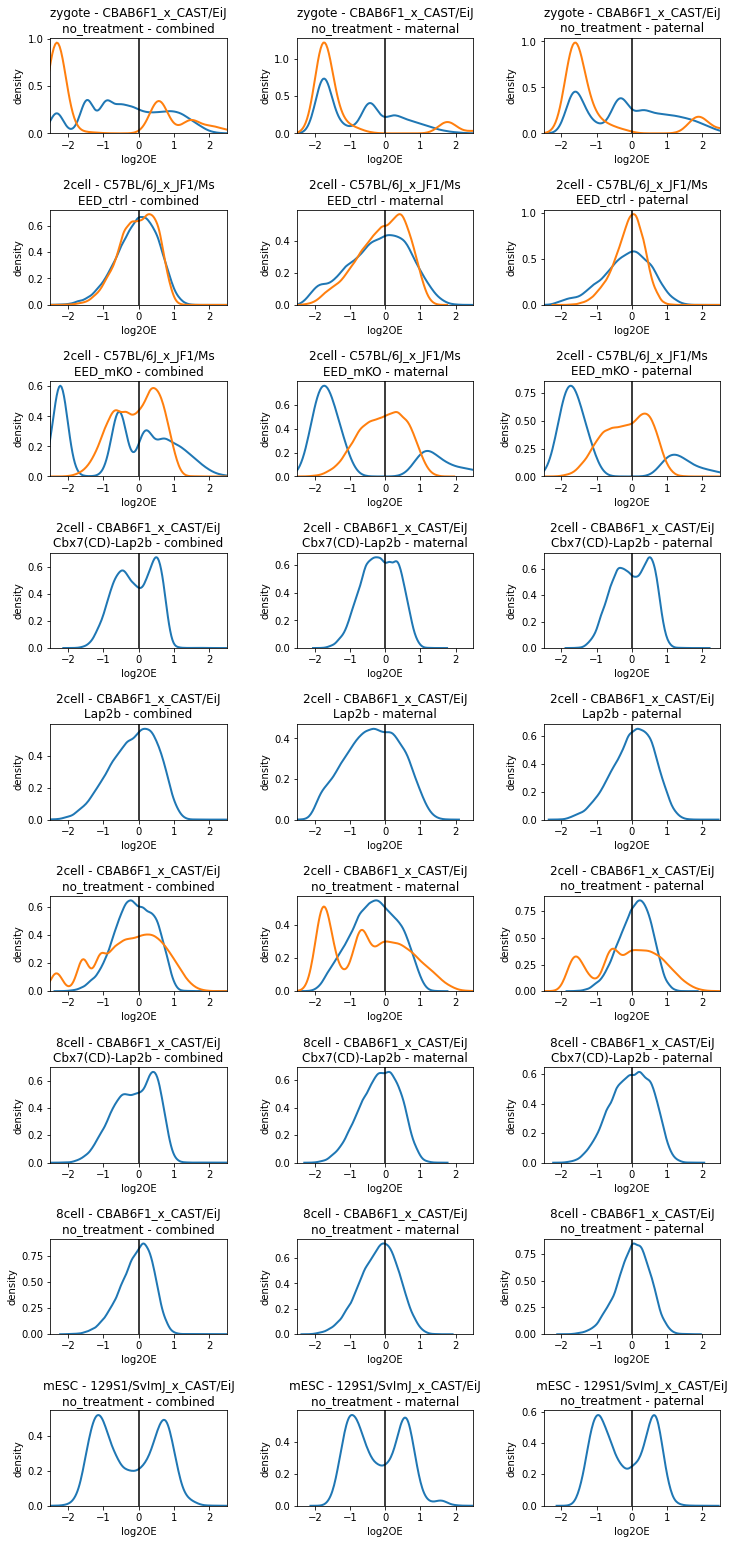

In [34]:
nrow = len(damid_insilico['combined'].keys())
ncol = 3

fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow))
plt.subplots_adjust(wspace=.4, hspace=.8)
r_counter = 0

m_ind = np.concatenate([mapab[c] for c in som_chrom]) > MINMAP

for info, _ in anno.groupby(['stage', 'genotype', 'treatment']):

    for icol, parent in enumerate(['combined', 'maternal', 'paternal']):
        
        ax = axes[r_counter, icol]
    
        for sample in insilico_pop_runid[parent]['log2oe']:
            if (sample[0], sample[1], sample[2]) != info:
                continue
                
            a_ind = np.concatenate([allele_filt_gt[sample[1]][c] for c in som_chrom])
            filt = m_ind if parent == 'combined' else a_ind & m_ind
                
            X = np.concatenate([insilico_pop_runid[parent]['log2oe'][sample][c] for c in som_chrom])[filt]
            sns.kdeplot(X, label='%s - %s' % (sample[-1], sample[-2]), ax=ax, lw=2)

#         if icol == (ncol-1):
#             ax.legend(loc=(1,0))
#         else:
#             ax.legend_.remove()
            
        ax.set_xlabel('log2OE')
        ax.set_ylabel('density')
        ax.set_xlim(-2.5,2.5)
        ax.axvline(0, c='k')
        ax.set_title('%s - %s\n%s - %s' % (info[0],info[1],info[2],parent))
    
    r_counter += 1
plt.show()